In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import tree
from sklearn.model_selection import train_test_split 
from sklearn import metrics
from scipy.stats import entropy
from random import seed
from random import randrange
from sklearn import preprocessing

In [2]:
data = pd.read_csv('coursework_2.csv')

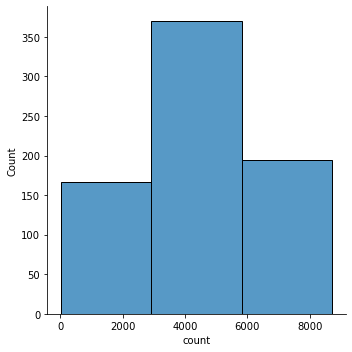

In [3]:
counts=data['count']
sns.displot(counts,bins=3)

In [4]:
bin_labels_3 = ['Low', 'Medium', 'High']
data['usage']=pd.qcut(data['count'], q=3,precision=0,labels=bin_labels_3)

In [5]:
data['usage']

0      Low
1      Low
2      Low
3      Low
4      Low
      ... 
726    Low
727    Low
728    Low
729    Low
730    Low
Name: usage, Length: 731, dtype: category
Categories (3, object): ['Low' < 'Medium' < 'High']

# Entropy

In [6]:
X = data[['season','workingday','weathersit']]
Y = data[['usage']]

In [7]:
Xtr, Xtest, Ytr, Ytest = train_test_split(X, Y, test_size=0.2)

In [8]:
def Attribute_information_gain(Xtr,Ytr,Xtest,Ytest):
    dt = tree.DecisionTreeClassifier(criterion='entropy') 
    model=dt.fit(Xtr, Ytr)
    info=model.feature_importances_
    classes=model.classes_
    output = pd.DataFrame({'information gain':info,'usage':classes})
    return output    

In [9]:
#Input any subset of the data to receive relative class entropies.
aig = Attribute_information_gain(Xtr,Ytr,Xtest,Ytest)

In [10]:
aig

,information gain,usage
0,0.680242,High
1,0.092373,Low
2,0.227385,Medium


In [11]:
print(
    "Attribute with the higest information gain: ",
    aig['usage'][aig['information gain'].idxmax()]
)

Attribute with the higest information gain:  High


# Tree from scratch

Code borrowed from:
https://machinelearningmastery.com/implement-decision-tree-algorithm-scratch-python/

In [12]:
# Split a dataset into k folds
def cross_validation_split(dataset, n_folds):
    dataset_split = list()
    dataset_copy = list(dataset)
    fold_size = int(len(dataset) / n_folds)
    for i in range(n_folds):
        fold = list()
        while len(fold) < fold_size:
            index = randrange(len(dataset_copy))
            fold.append(dataset_copy.pop(index))
        dataset_split.append(fold)
    return dataset_split

# Calculate accuracy percentage
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

# Evaluate an algorithm using a cross validation split
def evaluate_algorithm(dataset, algorithm, n_folds, *args):
        train_set , test_set = train_test_split(dataset,random_state=9)
        
        predicted = decision_tree(train_set, test_set, *args)
        actual = test_set[:,len(test_set[0])-1]
        accuracy = accuracy_metric(actual, predicted)
        
        return accuracy ,predicted

In [13]:
# Calculate the Gini index for a split dataset
def gini_index(groups, classes):
    # count all samples at split point
    n_instances = float(sum([len(group) for group in groups]))
    # sum weighted Gini index for each group
    gini = 0.0
    for group in groups:
        size = float(len(group))
        # avoid divide by zero
        if size == 0:
            continue
        score = 0.0
        # score the group based on the score for each class
        for class_val in classes:
            p = [row[-1] for row in group].count(class_val) / size
            score += p * p
        # weight the group score by its relative size
        gini += (1.0 - score) * (size / n_instances)
    
    return gini

In [14]:
# Split a dataset based on an attribute and an attribute value
def test_split(index, value, dataset):
    left, right = list(), list()
    for row in dataset:
        if row[index] < value:
            left.append(row)
        else:
            right.append(row)
    return left, right

In [15]:
# Select the best split point for a dataset
def get_split(dataset):
    class_values = list(set(row[-1] for row in dataset))
    b_index, b_value, b_score, b_groups = 999, 999, 999, None
    for index in range(len(dataset[0])-1):
        for row in dataset:
            groups = test_split(index, row[index], dataset)
            #print(groups)
            gini = gini_index(groups, class_values)
            #print(gini)
            if gini < b_score:
                b_index, b_value, b_score, b_groups = index, row[index], gini, groups
    return {'index':b_index, 'value':b_value, 'groups':b_groups}

In [16]:
# Create a terminal node value
def to_terminal(group):
    outcomes = [row[-1] for row in group]
    return max(set(outcomes), key=outcomes.count)

In [17]:
# Create child splits for a node or make terminal
def split(node, max_depth, min_size, depth):
    left, right = node['groups']
    del(node['groups'])
    # check for a no split
    if not left or not right:
        node['left'] = node['right'] = to_terminal(left + right)
        return
    # check for max depth
    if depth >= max_depth:
        node['left'], node['right'] = to_terminal(left), to_terminal(right)
        return
    # process left child
    if len(left) <= min_size:
        node['left'] = to_terminal(left)
    else:
        node['left'] = get_split(left)
        split(node['left'], max_depth, min_size, depth+1)
    # process right child
    if len(right) <= min_size:
        node['right'] = to_terminal(right)
    else:
        node['right'] = get_split(right)
        split(node['right'], max_depth, min_size, depth+1)

In [18]:
# Build a decision tree
def build_tree(train, max_depth, min_size):
    root = get_split(train)
    split(root, max_depth, min_size, 1)
    return root


# Print a decision tree
def print_tree(node, depth=0):
    if isinstance(node, dict):
        print('%s[X%d < %.3f]' % ((depth*' ', (node['index']+1), node['value'])))
        print_tree(node['left'], depth+1)
        print_tree(node['right'], depth+1)
    else:
        print('%s[%s]' % ((depth*' ', node)))

In [19]:
# Make a prediction with a decision tree
def predict(node, row):
    if row[node['index']] < node['value']:
        if isinstance(node['left'], dict):
            return predict(node['left'], row)
        else:
            return node['left']
    else:
        if isinstance(node['right'], dict):
            return predict(node['right'], row)
        else:
            return node['right']
        
        
# Classification and Regression Tree Algorithm
def decision_tree(train, test, max_depth, min_size):
    tree = build_tree(train, max_depth, min_size)
    predictions = list()
    for row in test:
        prediction = predict(tree, row)
        predictions.append(prediction)
    return(predictions)

In [20]:
seed(1)
n_folds = 5
max_depth = 5
min_size = 10

X = data[['season','workingday','weathersit']]
Y = data[['usage']]

dataset=X
dataset['usage']=Y
dataset=np.array(dataset)
pd.DataFrame(dataset).describe()

<ipython-input-20-21b2f8b1c9b4>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['usage']=Y


,0,1,2,3
count,731,731,731,731
unique,4,2,3,3
top,3,1,1,Medium
freq,188,500,463,244


In [21]:
accuracy,predicted = evaluate_algorithm(dataset, decision_tree, n_folds, max_depth, min_size)
   
print('Accuracy: %s' % accuracy)

Accuracy: 55.73770491803278


# Optimisation

In [22]:
n_folds = 5
max_depth = 5
min_size = 10

X = data[['season','workingday','weathersit']]
Y = data[['usage']]

dataset=X
dataset['usage']=Y
dataset=np.array(dataset)
pd.DataFrame(dataset).describe()

<ipython-input-22-3b78bb0c0bfd>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['usage']=Y


,0,1,2,3
count,731,731,731,731
unique,4,2,3,3
top,3,1,1,Medium
freq,188,500,463,244


In [23]:
array={'accuracy':[],'value of i':[]}
for i in range(20):
    n_folds = i
    max_depth = i
    min_size = i
    accuracy,predicted = evaluate_algorithm(dataset, decision_tree, n_folds, max_depth, min_size)
    array['accuracy'].append(accuracy)
    array['value of i'].append(i)

Text(0, 0.5, 'Accuracy')

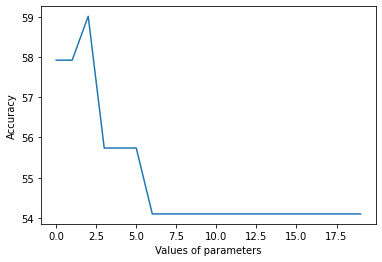

In [24]:
sns.lineplot(x=array['value of i'],y=array['accuracy'])
plt.xlabel('Values of parameters')
plt.ylabel('Accuracy')

### Optimal estimator without tempbins

In [25]:
n_folds = 2.5
max_depth = 2.5
min_size = 2.5
accuracy,predicted = evaluate_algorithm(dataset, decision_tree, n_folds, max_depth, min_size)
print('Accuracy: %s' % accuracy)

Accuracy: 55.73770491803278


# Tempbins

In [26]:
X = data[['season','workingday','weathersit']]
Y = data[['usage']]
dataset=[]
temps=data['temp']
dataset=X
dataset['tempbins']=pd.qcut(temps, q=3,precision=0,labels=bin_labels_3)

le = preprocessing.LabelEncoder()
dataset['tempbins']=le.fit_transform(dataset['tempbins'])
dataset['usage']=Y
dataset=np.array(dataset)

pd.DataFrame(dataset).describe()

<ipython-input-26-5faa19f3b593>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['tempbins']=pd.qcut(temps, q=3,precision=0,labels=bin_labels_3)
<ipython-input-26-5faa19f3b593>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['tempbins']=le.fit_transform(dataset['tempbins'])
<ipython-input-26-5faa19f3b593>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

,0,1,2,3,4
count,731,731,731,731,731
unique,4,2,3,3,3
top,3,1,1,2,Medium
freq,188,500,463,244,244


In [27]:
accuracy,predicted = evaluate_algorithm(dataset, decision_tree, n_folds, max_depth, min_size)
print('Accuracy: %s' % accuracy)


tree = build_tree(dataset, max_depth, min_size)
print_tree(tree)

Accuracy: 54.644808743169406
[X1 < 2.000]
 [X4 < 2.000]
  [X3 < 2.000]
   [Low]
   [Low]
  [X3 < 3.000]
   [Low]
   [Low]
 [X4 < 1.000]
  [X3 < 3.000]
   [High]
   [Low]
  [X4 < 2.000]
   [Low]
   [High]
